# A COMBINED CORNER AND EDGE DETECTOR

<http://www.bmva.org/bmvc/1988/avc-88-023.pdf>

The "Harris Corner Detector" is used in many CV applications.

1. The paper generalises the SSD maximisation approach proposed in [Moravec's corner detection algorithm](https://en.wikipedia.org/wiki/Corner_detection#Moravec_corner_detection_algorithm) from 1980.
2. Instead of specific movements and rotations it uses spatial gradients to detect change in a window.
3. Image smoothening is applies to minimise effect of noise and extract smooth gradients.
4. The algorithm break down corner detection into an inspection of the gradient self-correlation matrix.
5. Eigenvalues of this matrix can be used to label a point as a corner, edge or normal surface.
6. Instead of computing the eigenvalues, the paper proposes a heuristic $R$ to determine the "cornerness" of a point.

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [4]:
from tqdm import tqdm_notebook

### Image loading stuff.

1. Load as grayscale.
2. Convert to `float32` -- it's `uint8` after loading from `cv2`.
3. Downsample.
4. Blur.
5. Plot... for sanity.

In [5]:
img = cv2.imread('/Users/tejaswin.p/Downloads/Fast_Brief/IMG_20200415_162333.jpg', cv2.IMREAD_GRAYSCALE)

In [6]:
img = np.float32(img)

In [7]:
img = cv2.resize(img, (0, 0), fx=0.1, fy=0.1)

In [8]:
blur = cv2.GaussianBlur(img, (5, 5), 0)

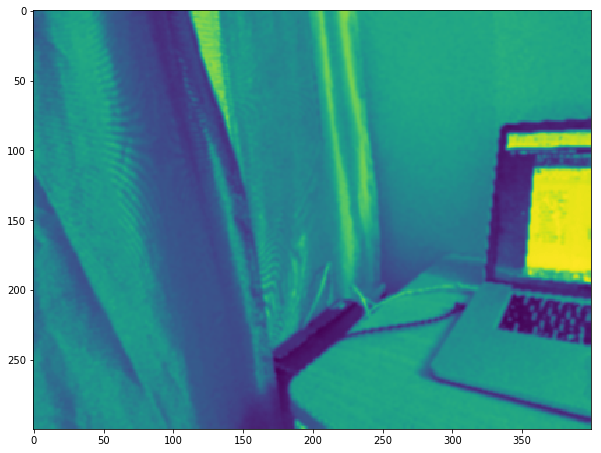

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(blur);

### Find derivatives

1. For $I_x$, iterate over every column from 1 to $n-1$
2. Store in place next col - current col.
3. Skip or pad the edges.

Repeat the same procedure for every row.
This implements a poorly coded Sobel filter.

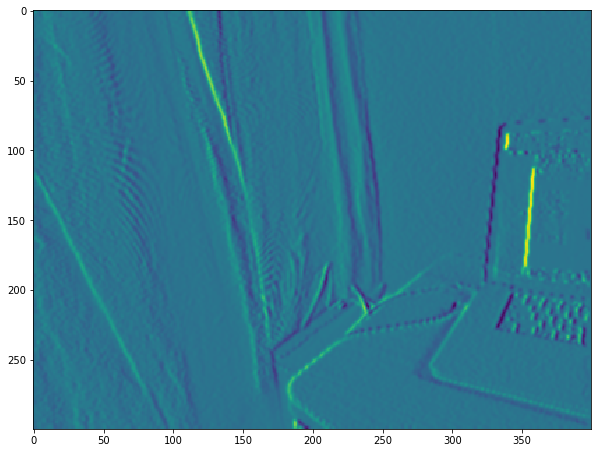

In [11]:
ix = np.zeros_like(blur)
for c in range(1, ix.shape[1]-1):
    ix[:, c] = blur[:, c+1] - blur[:, c-1]
    
plt.figure(figsize=(10, 10))
plt.imshow(ix);

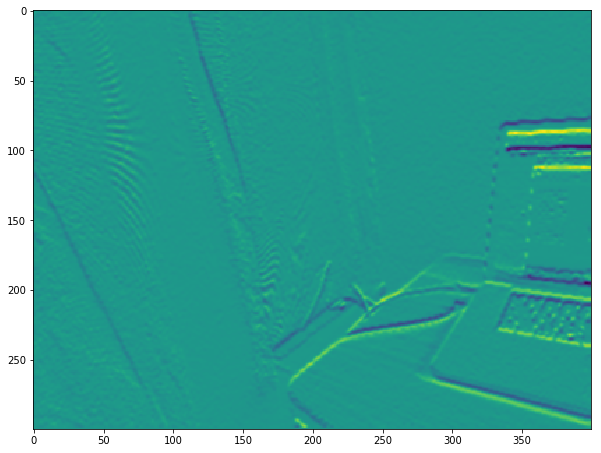

In [12]:
iy = np.zeros_like(blur)
for r in range(1, ix.shape[0]-1):
    iy[r, :] = blur[r+1, :] - blur[r-1, :]
    
plt.figure(figsize=(10, 10))
plt.imshow(iy);

### Compute Harris Response

For every patch in the image, compute matrix
$M = \begin{bmatrix} A & C \\ C & B \end{bmatrix}$

where

$A = \sum_{(x, y) \in W}I_x^2$

$B = \sum_{(x, y) \in W}I_y^2$

$C = \sum_{(x, y) \in W}I_x I_y$

$I_x, I_y$ are the spatial image derivatives and $W$ is the patch.

Inspecting the eigenvalues of $M$ allows us to label the feature as corner, edge or plain point.

However, the paper also proposes the following huristic:

$R = \text{det}(M) - k.\text{tr}(M)^2$, where $k$ is empirically determined to be in $[0.04, 0.06]$

In [13]:
window = 3
limit = (window-1)/2

harris_response = np.zeros_like(blur)

for i in tqdm_notebook(range(limit, blur.shape[0]-limit)):
    for j in range(limit, blur.shape[1]-limit):
        patch_x = ix[i-limit : i+limit+1, j-limit : j+limit+1]
        patch_y = iy[i-limit : i+limit+1, j-limit : j+limit+1]
        
        ma = np.sum(np.square(patch_x))
        mb = np.sum(np.square(patch_y))
        mc = np.sum(np.multiply(patch_x, patch_y))
        
        mr = (ma * mb - mc**2) - (0.04 * (ma + mb)**2)
        
        harris_response[i, j] = mr

Threshold for the top Harris Response pixels.

In the image below, the *highlighted* specs are the detected corners.

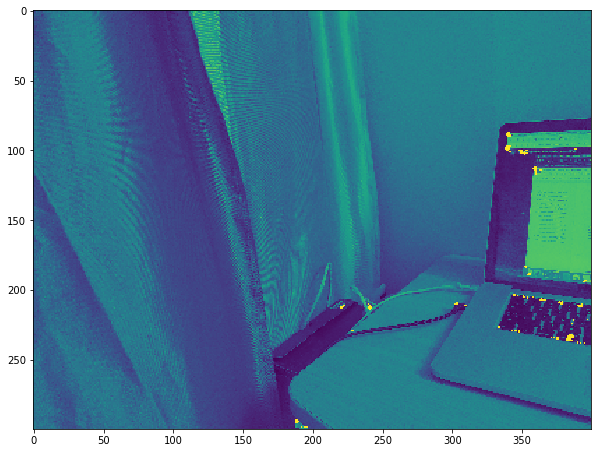

In [16]:
corners = np.copy(img)
corners = corners * 0.8
corners[harris_response > 0.03 * harris_response.max()] = 255
plt.figure(figsize=(10, 10))
plt.imshow(corners);

### NMS

We can remove multiple adjacent corner pixels by taking the local maxima -- Non-Maximal Suppression.

In a patch, simply ignore all pixel responses except for the largest one.

In [17]:
harris_nms = np.zeros_like(blur)

counter = 0

for i in tqdm_notebook(range(harris_response.shape[0]-window)):
    for j in range(harris_response.shape[1]-window):
        values = []
        for a in range(window):
            for b in range(window):
                values.append((harris_response[i+a, j+b], (i+a, j+b)))
                
        winner_val, winner_loc = sorted(values)[-1]
            
        harris_nms[winner_loc[0], winner_loc[1]] = winner_val

The next image highlights the post-NMS pixels using `Matplotlib Patches` in red.

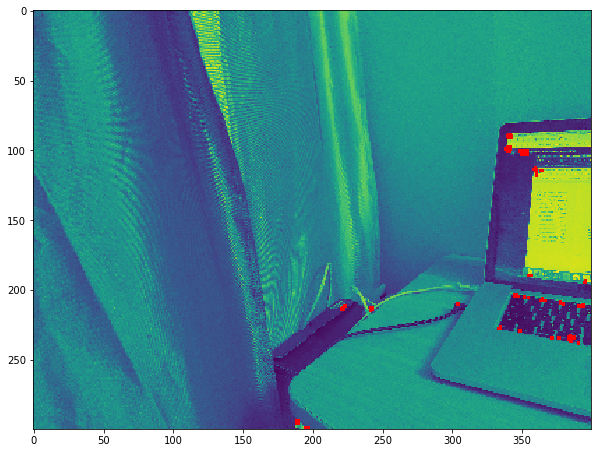

In [19]:
corners = np.zeros_like(img)
corners[harris_nms > 0.04 * harris_nms.max()] = 255

plt.figure(figsize=(10, 10))
ax = plt.gca()

for i in range(corners.shape[0]):
    for j in range(corners.shape[1]):
        if corners[i, j] == 255:
            _p = patches.Rectangle((j, i), 1, 1, fill=False, linewidth=2, color='red')
            ax.add_patch(_p)
            
plt.imshow(img);